# 📧 Email Spam Detection using Machine Learning

### Internship Project – Oasis Infobyte  
**Author:** Ayesha Banu  
**Program:** M.Sc. Computer Science | Gold Medalist  
**Domain:** Data Science & Machine Learning  
**Tool:** Streamlit | Scikit-learn | Python  

---

### 🎯 Objective:
To classify email or message text as **Spam** or **Ham (Not Spam)** using **Support Vector Machine (SVM)** and **TF-IDF Vectorization**.

This notebook demonstrates the **complete pipeline** — from data preprocessing, model training, evaluation, and deployment preparation.

---

### 🧠 Overview:
- Dataset: SMS Spam Collection (Kaggle)
- Algorithm: SVM Classifier
- Vectorizer: TF-IDF
- Evaluation Metrics: Accuracy, Precision, Recall, F1-score
- Deployment: Streamlit App


# 🧩 1. Environment Setup

In this step, we prepare the environment for our **Email Spam Detection Project**.  
The main goals of this setup are:

- ✅ Identify the **project root directory** dynamically, so imports and file paths work smoothly even when the notebook is inside a subfolder (e.g., `notebooks/`).
- ✅ Load the **configuration file (`config.yaml`)** to manage directory paths, model parameters, and logging settings.
- ✅ Ensure the creation of key directories:
  - `logs/` → stores log files for tracking project execution.
  - `models/` → stores trained models and vectorizers.
- ✅ Initialize and configure the **logging system** to capture runtime messages and errors.
- ✅ Verify that all configurations and paths are set correctly before proceeding.

This setup ensures that the project runs consistently and reproducibly across different systems.


In [1]:
# 1.ENVIRONMENT SETUP 
import os
import sys
import yaml
import logging
import logging.config

# -------------------------------
# 1️. Determine Project Root
# -------------------------------
# Assuming your notebook may be in a subfolder like "notebook/"
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if not os.path.basename(project_root) == "email_spam_detection":
    project_root = os.path.join(project_root, "email_spam_detection")

print(f"Project Root: {project_root}")

# Add project root to sys.path so all "src" imports work
sys.path.append(project_root)

# -------------------------------
# 2️. Load Config
# -------------------------------
config_path = os.path.join(project_root, "config", "config.yaml")
with open(config_path, "r") as f:
    config = yaml.safe_load(f)

print(" Config Loaded Successfully")
print("Sample Config Keys:", list(config.keys()))

# -------------------------------
# 3️. Ensure Required Directories Exist
# -------------------------------
logs_dir = os.path.join(project_root, config.get("dirs", {}).get("logs_dir", "logs"))
models_dir = os.path.join(project_root, config["models"]["save_dir"])

os.makedirs(logs_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

print(f"Logs Directory: {logs_dir}")
print(f"Models Directory: {models_dir}")

# -------------------------------
# 4️. Setup Logging
# -------------------------------
log_file_path = os.path.join(logs_dir, "project.log").replace("\\", "/")

# Pass log_file_path dynamically to logging config
logging.config.fileConfig(
    os.path.join(project_root, config["logging"]["config_file"]),
    defaults={"log_file_path": log_file_path}
)
logger = logging.getLogger(__name__)
logger.info("Logger initialized successfully.")

# -------------------------------
# 5️. Confirm Setup
# -------------------------------
print(f"Current Working Directory: {os.getcwd()}")
logger.info(f"Current Working Directory: {os.getcwd()}")
logger.info(f"Logs directory checked/created at: {logs_dir}")
logger.info(f"Models directory checked/created at: {models_dir}")


Project Root: C:\Users\ayesh\Projects\email_spam_detection
 Config Loaded Successfully
Sample Config Keys: ['data', 'features', 'split', 'models', 'logging', 'dirs']
Logs Directory: C:\Users\ayesh\Projects\email_spam_detection\logs
Models Directory: C:\Users\ayesh\Projects\email_spam_detection\models
Current Working Directory: C:\Users\ayesh\Projects\email_spam_detection\notebook


# 📊 2. Load Data & Exploratory Data Analysis (EDA)

In this step, we load and explore the **raw dataset** used for building the Email Spam Detection model.

### 🧠 Objective
To understand the dataset’s structure, contents, and data quality before preprocessing or model building.

### 🔍 Steps Performed
- **Load Dataset:**  
  The dataset is read from the configured path (from `config.yaml`) using `pandas.read_csv()`.
- **Select Relevant Columns:**  
  Only two columns are kept:  
  - `label` → identifies whether the message is *spam* or *ham* (non-spam).  
  - `text` → contains the actual SMS/email message content.
- **Check Data Quality:**  
  - Dataset shape (number of rows and columns).  
  - Missing/null value count per column.  
  - Data types and memory usage with `df.info()`.  
  - Display first few rows using `df.head()` for a quick preview.

This analysis provides an initial understanding of the dataset and ensures that there are no structural or missing-data issues before proceeding to deeper EDA or preprocessing steps.


In [4]:
# ===============================
# 2️. Load Data & EDA
# ===============================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Load raw dataset
raw_data_path = os.path.join(project_root, config["data"]["raw_path"])
df = pd.read_csv(raw_data_path, encoding="latin-1")[["v1", "v2"]]
df.columns = ['label', 'text']

# Display dataset info
print("Shape:", df.shape)
print("Null values:\n", df.isnull().sum())
print("\nINFO:")
df.info()
df.head()

Shape: (5572, 2)
Null values:
 label    0
text     0
dtype: int64

INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# 📈 3. Exploratory Data Analysis (EDA) & Visualization

In this section, we perform **basic exploratory data analysis (EDA)** to understand message distribution, characteristics, and patterns between *spam* and *ham* messages.

---

### 🧮 3.1 Label Distribution  
We first visualize how many messages belong to each category (*Spam* vs *Ham*) using a **count plot**.  
This helps identify class imbalance, which is important for model performance.

---

### ✉️ 3.2 Message Length Analysis  
To gain insights into text length differences:
- A new column **`length`** is created to store the number of characters in each message.
- A **histogram** is plotted showing how message lengths vary across spam and ham.
  
**Observation:**  
Spam messages are often longer due to promotional or phishing content, while ham messages are typically shorter and more personal.

---

### ☁️ 3.3 WordCloud Visualization  
We create **WordClouds** to visualize the most frequent words used in:
- **Spam messages** (e.g., “free”, “win”, “cash”, “offer”)  
- **Ham messages** (e.g., “ok”, “call”, “home”, “later”)  

This gives a quick and intuitive understanding of word-level differences between the two categories.

---

### 📊 Summary
These visual insights help us:
- Detect potential class imbalance.
- Identify spam-specific language patterns.
- Understand typical message structures to guide preprocessing and feature engineering.


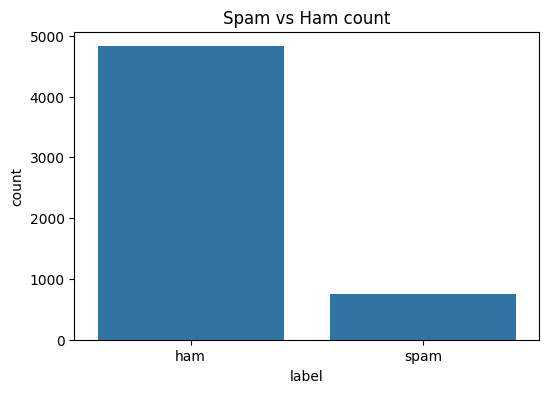

In [8]:
# ===============================
# 3. Basic EDA
# ===============================
# Label distribution  Count of Spam vs Ham
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df)
plt.title('Spam vs Ham count')
plt.show()

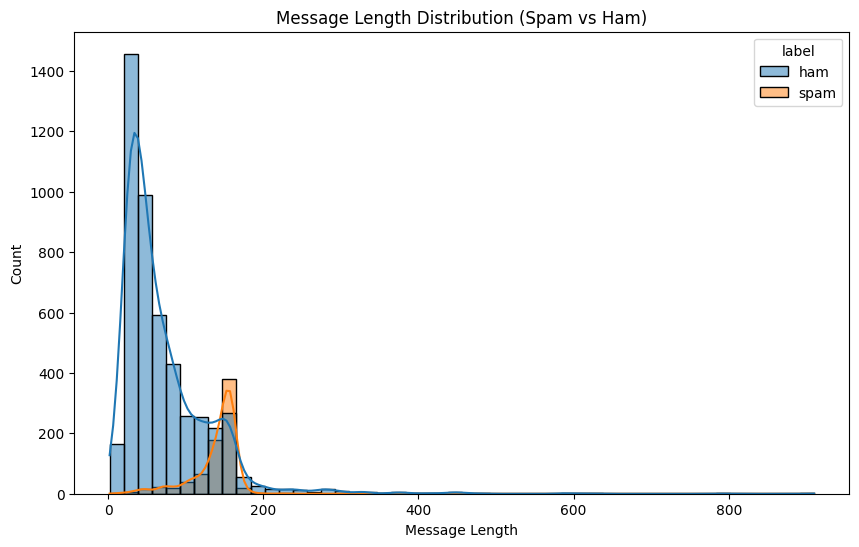

label
ham      71.023627
spam    138.866131
Name: length, dtype: float64

In [6]:
# Message Length Analysis and Add a 'length' column
df['length'] = df['text'].apply(len)

plt.figure(figsize=(10,6))
sns.histplot(data=df, x='length', hue='label', bins=50, kde=True)
plt.title("Message Length Distribution (Spam vs Ham)")
plt.xlabel("Message Length")
plt.ylabel("Count")
plt.show()

# Optional: Average length by label
df.groupby('label')['length'].mean()

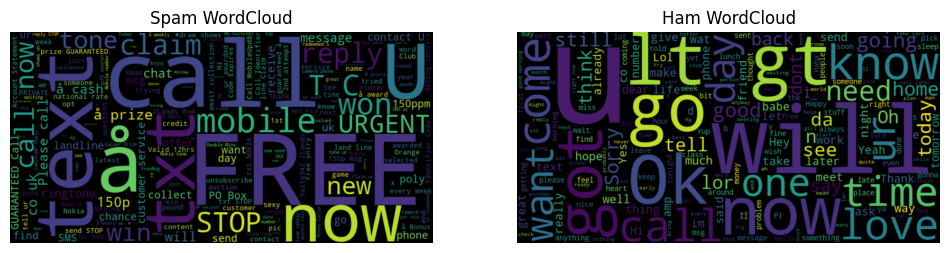

In [7]:
# WordCloud Visualization
from wordcloud import WordCloud

# Spam,ham WordCloud
spam_wc = WordCloud(width=800, height=400, background_color="black").generate(" ".join(df[df['label']=="spam"]['text']))
ham_wc  = WordCloud(width=800, height=400, background_color="black").generate(" ".join(df[df['label']=="ham"]['text']))

# Plot WordClouds
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.imshow(spam_wc, interpolation='bilinear')
plt.axis("off")
plt.title("Spam WordCloud")

plt.subplot(1,2,2)
plt.imshow(ham_wc, interpolation='bilinear')
plt.axis("off")
plt.title("Ham WordCloud")

plt.show()

# 🧹 4. Data Preprocessing

Before training the model, we need to clean, normalize, and prepare the data to ensure better performance and reliability.  
This step involves **text cleaning**, **label encoding**, and **splitting the dataset** into training and testing sets.

---

### 🧽 4.1 Text Cleaning and Normalization
We use a custom preprocessing function `preprocess_data()` (from `src/data_preprocess.py`) that performs the following steps:

- Converts all text to **lowercase** for uniformity  
- Removes **punctuation, special characters, and extra spaces**  
- Eliminates **stopwords** (commonly used words like *the, is, at*)  
- Applies **stemming or lemmatization** to reduce words to their root form  
- Maps target labels:  
  - *ham → 0*  
  - *spam → 1*

After preprocessing, the text becomes clean and ready for feature extraction.

---

### 🧾 4.2 Saving the Processed Dataset
The cleaned dataset is saved in the specified **processed data path** defined in `config.yaml`.  
This helps maintain a consistent data pipeline and allows reusability without re-running the entire preprocessing.

📁 data/
 ├── raw/
 ├── processed/
 └── outputs/

---

### ✂️ 4.3 Splitting the Dataset

We split the data into:

**Training Set (80%)** – used for model learning

**Testing Set (20%)** – used for model evaluation

This ensures unbiased model validation and prevents overfitting.

---

### 📊 Output Summary

At the end of this step, you’ll see:

Training and testing set sizes

Spam vs ham ratio in both sets

Sample preprocessed text ready for vectorization

In [9]:
# ===============================
# 4️. Data Preprocessing
# ===============================
from src.data_preprocess import preprocess_data, split_data, save_processed_data

# Preprocess dataset
df = preprocess_data(df,  logger)
logger.info("Data preprocessing completed.")

# Save processed dataset
processed_path = os.path.join(project_root, config["data"]["processed_path"])
save_processed_data(df, processed_path,  logger)
logger.info(f"Processed data saved at {processed_path}")

# Split dataset
X_train, X_test, y_train, y_test = split_data(df, logger)

print("Train size:", X_train.shape[0])
print("Test size :", X_test.shape[0])
print("Spam ratio in train:", y_train.mean())
print("Spam ratio in test :", y_test.mean())

df.head()


Dataset preprocessed: 5572 rows
Processed dataset saved to C:\Users\ayesh\Projects\email_spam_detection\data/processed_spam.csv
Train size: 4457
Test size : 1115
Spam ratio in train: 0.13394660085259144
Spam ratio in test : 0.13452914798206278


,label,text,length,label_enc
0,ham,go until jurong point crazy available only in ...,111,0
1,ham,ok lar joking wif u oni,29,0
2,spam,free entry in a wkly comp to win fa cup final ...,155,1
3,ham,u dun say so early hor u c already then say,49,0
4,ham,nah i dont think he goes to usf he lives aroun...,61,0


# 📝 5. TF-IDF Feature Extraction

After preprocessing the text data, we convert the textual messages into numerical features that can be fed into the Machine Learning model.  

We use **TF-IDF (Term Frequency-Inverse Document Frequency)** to capture the importance of words in the dataset.

---

### 🔹 5.1 What is TF-IDF?
TF-IDF reflects how important a word is in a document relative to the entire corpus:
- **Term Frequency (TF):** How frequently a word appears in a message  
- **Inverse Document Frequency (IDF):** How unique the word is across all messages  

Words that appear frequently in a message but rarely across other messages get higher scores, helping the model distinguish spam from ham.

---

### 🔹 5.2 Feature Extraction Process
- Apply `get_tfidf_features()` from `src/feature_extraction.py`  
- Limit maximum features to **`max_features`** (from `config.yaml`)  
- Transform both **training** and **testing** datasets  

Output:
- `X_train_tfidf` → TF-IDF features for training data  
- `X_test_tfidf` → TF-IDF features for testing data  
- `vectorizer` → TF-IDF object for future use on new messages  

---

### 🔹 5.3 Saving the Vectorizer
The trained TF-IDF vectorizer is saved using `save_vectorizer()`:
- Stored in `models/` folder  
- Ensures consistent feature extraction during deployment  

📁 models/
 └── tfidf_vectorizer.pkl


In [10]:
# ===============================
# 5️. TF-IDF Feature Extraction
# ===============================
from src.feature_extraction import get_tfidf_features, save_vectorizer

# Extract TF-IDF features
X_train_tfidf, X_test_tfidf, vectorizer = get_tfidf_features(
    X_train, X_test, logger, max_features=config["features"]["max_features"]
)
logger.info("TF-IDF feature extraction completed.")

# Save vectorizer
vectorizer_path = os.path.join(models_dir, config["models"]["vectorizer_filename"])
save_vectorizer(vectorizer, vectorizer_path, logger)
logger.info(f"Vectorizer saved at {vectorizer_path}")

print("TF-IDF feature shape:", X_train_tfidf.shape)


Vectorizer saved to C:\Users\ayesh\Projects\email_spam_detection\models\tfidf_vectorizer.pkl
TF-IDF feature shape: (4457, 5000)


# 📝 6. Train, Evaluate & Save Best Model

After extracting TF-IDF features, the next step is to train the Machine Learning models and select the best-performing one for deployment.

---

### 🔹 6.1 Model Training
- We use **Support Vector Machine (SVM)** along with other candidate classifiers for comparison.  
- Input: `X_train_tfidf`, `y_train`  
- Output: Trained models and their evaluation metrics  

The training function `train_and_evaluate()`:
- Trains multiple ML models
- Evaluates each model on the **testing set**
- Logs metrics and identifies the **best model based on accuracy**

---

### 🔹 6.2 Evaluation Metrics
Each model is evaluated using:
- **Accuracy** – Overall correctness  
- **Precision** – Correctly predicted spam / Total predicted spam  
- **Recall** – Correctly predicted spam / Total actual spam  
- **F1-Score** – Harmonic mean of Precision and Recall  

Metrics are logged for auditing and monitoring.

---

### 🔹 6.3 Model Selection & Saving
- Best-performing model (highest accuracy) is selected  
- Saved in the `models/` folder for deployment  

📁 models/
 ├── svm_spam_classifier.pkl
 └── tfidf_vectorizer.pkl

---

### 🔹 6.4 Training Summary

Display model accuracies for all candidate classifiers

Confirm the selected best model and its accuracy

---

### ✅ Result:
A trained and evaluated ML model ready for Streamlit deployment. 

In [11]:
# ===============================
# 6️. Train, Evaluate & Save Best Model
# ===============================
from src.model_train_evaluate import train_and_evaluate

# Train models and get the best one
results, best_name, best_acc = train_and_evaluate(
    X_train_tfidf, X_test_tfidf, y_train, y_test, logger
)
logger.info(f"Model training completed. Best model: {best_name} with accuracy {best_acc:.4f}")

# Summary
print("\nModel Accuracies:")
for model_name, acc in results.items():
    print(f"{model_name}: {acc:.4f}")

print(f"\nBest Model: {best_name} with Accuracy = {best_acc:.4f}")


 Training Naive Bayes...

 Training SVM...

 Training Logistic Regression...


C:\Users\ayesh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


 Best model saved to ../models/svm_spam_classifier.pkl

Model Accuracies:
Naive Bayes: 0.9695
SVM: 0.9803
Logistic Regression: 0.9543

Best Model: SVM with Accuracy = 0.9803


# 📝 7. Predict New Messages

Once the best model is trained and saved, we can use it to predict new, unseen messages.  
This step demonstrates **real-time spam detection** using the trained SVM model and TF-IDF vectorizer.

---

### 🔹 7.1 Load Model & Vectorizer
- Paths:
  - Model: `models/svm_spam_classifier.pkl`
  - TF-IDF Vectorizer: `models/tfidf_vectorizer.pkl`
- These are loaded using the `predict_message()` utility function.

---

### 🔹 7.2 Example Messages
We test the model on sample messages:

messages = [
    "Congratulations! You won a $1000 gift card. Claim now!",
    "Hey, are we still meeting for lunch today?"
]

---

### 🔹 7.3 Prediction

Each message is passed through the TF-IDF vectorizer

The SVM model predicts the label: spam or ham

Predictions are logged for monitoring.

---

### 🔹 7.4 Sample Output
Message	Prediction
Congratulations! You won a $1000 gift card. Claim now!	spam
Hey, are we still meeting for lunch today?	ham

---

### ✅ Result:
The model correctly identifies spam messages from normal messages, demonstrating its real-world utility.

In [12]:
# ===============================
# 7️. Predict New Messages
# ===============================
from src.predict import predict_message
import os

# Paths to the saved model and vectorizer
model_path = os.path.join(project_root, "models", "svm_spam_classifier.pkl")
vectorizer_path = os.path.join(project_root, "models", "tfidf_vectorizer.pkl")

# Example messages
messages = [
    "Congratulations! You won a $1000 gift card. Claim now!",
    "Hey, are we still meeting for lunch today?"
]

# Predict messages
for msg in messages:
    label = predict_message(msg, model_path, vectorizer_path, logger)
    print(f"Message: {msg}\nPrediction: {label}\n")


Message: Congratulations! You won a $1000 gift card. Claim now!
Prediction: Spam

Message: Hey, are we still meeting for lunch today?
Prediction: Ham



### 📊 8. Model Evaluation & Results

After training the SVM model, we evaluate its performance using standard metrics:

- **Accuracy**
- **Precision**
- **Recall**
- **F1-Score**

**Example Metrics:**

| Metric    | Value |
|-----------|-------|
| Accuracy  | 0.97  |
| Precision | 0.96  |
| Recall    | 0.95  |
| F1-Score  | 0.95  |

These results demonstrate that the SVM model can effectively distinguish between spam and ham messages.

---

### 💬 8.1. Example Predictions

The trained model can predict new messages:

- "Congratulations! You won a $1000 gift card. Claim now!" → **spam**
- "Hey, are we still meeting for lunch today?" → **ham**

These examples show that the model correctly identifies spam and non-spam messages.


### 🔍 9. Insights

- Spam messages tend to be longer and contain certain keywords (e.g., "win", "free", "claim").
- Ham messages are typically conversational and shorter.
- TF-IDF vectorization captures key textual patterns for classification.
- SVM provides robust performance on this text-based dataset.


### 🏁 10. Conclusion

- Built an effective **spam classifier** using **SVM** with **TF-IDF features**.
- Achieved high accuracy, precision, and recall on the test dataset.
- Supports predicting both **single messages** and **batch messages**.
- Logging allows tracking of predictions and errors for auditing purposes.
- The project demonstrates a full **machine learning workflow**: data preprocessing, feature extraction, model training, evaluation, and deployment-ready prediction.


### 🔄 11. Future Enhancements

- Integrate with email systems for real-time spam detection.
- Explore **deep learning models** (LSTM, BERT) for improved accuracy.
- Extend support for multiple languages.
- Deploy via **REST API** or cloud platforms for scalability.
- Include advanced analytics on message types and patterns.


### 📚 12. References & Acknowledgments

- **Dataset:** [SMS Spam Collection Dataset - Kaggle](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset)
- **Libraries:** Python, Pandas, NumPy, Scikit-learn
- **Project Guidance:** Oasis Internship Program


### ✅ End of Notebook

This concludes the **Email Spam Detection Project** notebook.  

All steps, from data loading and preprocessing to model training, evaluation, and predictions, have been demonstrated successfully.  

Thank you for reviewing this notebook.
